In [1]:
from itertools import islice

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matching.glema.common.utils.arg_utils as arg_utils
import matching.glema.common.utils.graph_utils as graph_utils
import matching.glema.common.utils.misc_utils as misc_utils
import matching.glema.common.utils.model_utils as model_utils
import matching.glema.common.utils.plot_utils as plot_utils
import matching.glema.evaluation.evaluate_pattern_matching as epm
from matching.glema.common.dataset import DesignPatternDataset
from matching.glema.common.model import InferenceGNN
import matching.misc.cpg_const as cpg_const

In [2]:
args = arg_utils.parse_args( use_default=True )
args.dataset = "CPG_augm_large"
args.directed = False
args.anchored = True
version = model_utils.get_latest_model_version( args )
model_name = model_utils.get_model_name( args, version )
args = arg_utils.load_args( args, model_name )

args.pattern_dataset = "CPG_all"
args.normalized = True
args.test_data = True
args.batch_size = 128
args.num_workers = 1

In [3]:
model = InferenceGNN( args )

Loading model from /Users/jeanjour/Documents/projects/python/dpd-subgraph-matching/matching/glema/training/save/CPG_augm_large_undirected_anchored_v1/model.pt ...


In [4]:
dataset = DesignPatternDataset( args, max_pattern_examples=30, query_pattern=False )
epm.filter_sources( dataset, max_sources_per_pattern=10 )
epm.normalize_sources( dataset, max_distance=8 )
#normalize_patterns( dataset, max_distance=8 )
epm.normalize_patterns_by_presence( dataset, num_graphs=1, max_distance=8, n_min=16, cut_at_n=30 )
dataset.compute_samples()

Loading sources from CPG_augm_large ...


100%|██████████| 1220/1220 [00:00<00:00, 2714.77it/s]


Loading sources from CPG_all ...


100%|██████████| 22072/22072 [00:06<00:00, 3655.53it/s]


Filtering sources ...


100%|██████████| 1220/1220 [00:00<00:00, 4818315.33it/s]


Normalizing sources ...


100%|██████████| 72/72 [00:01<00:00, 36.27it/s] 


Normalizing patterns to connected ...


100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


Filter connected patterns by presence ...


100%|██████████| 7/7 [00:00<00:00, 1699.47it/s]


In [5]:
source_pattern_counts = { }
for gidx, pattern in dataset.get_source_patterns().items():
    if gidx not in dataset.get_sources():
        continue
    if pattern not in source_pattern_counts:
        source_pattern_counts[ pattern ] = 0
    source_pattern_counts[ pattern ] += 1
print( "source_pattern_counts:", misc_utils.sort_dict_by_key( source_pattern_counts ) )

pattern_example_counts = { dp: len( l ) for dp, l in dataset.get_patterns().items() }
print( "pattern_example_counts:", misc_utils.sort_dict_by_key( pattern_example_counts ) )

source_pattern_counts: {'ABSTRACT_FACTORY': 10, 'ADAPTER': 10, 'BUILDER': 10, 'FACADE': 7, 'FACTORY_METHOD': 10, 'N/A': 10, 'OBSERVER': 10, 'SINGLETON': 5}
pattern_example_counts: {'ABSTRACT_FACTORY': 1, 'ADAPTER': 1, 'BUILDER': 1, 'FACADE': 1, 'FACTORY_METHOD': 1, 'OBSERVER': 1, 'SINGLETON': 1}


In [6]:
def calculate_weighted_score( predictions, conf=0.5 ):
    # Split predictions into positive and negative counts
    pos_preds = [ p for p in predictions if p > conf ]
    neg_preds = [ p for p in predictions if p <= conf ]

    pos_count = len( pos_preds )
    neg_count = len( neg_preds )
    total_count = pos_count + neg_count

    if total_count == 0:
        return 0.0

    # Calculate the ratio of positive predictions
    pos_ratio = pos_count / total_count

    # Weight positive predictions higher if there are more positives
    pos_weight = pos_ratio
    neg_weight = 1 - pos_weight

    # Calculate the weighted average
    weighted_score = (pos_weight * sum( pos_preds ) / max( pos_count, 1 ) +
                      neg_weight * sum( neg_preds ) / max( neg_count, 1 )) / total_count

    return min( max( weighted_score, 0 ), 1 )


def calculate_top_score_mean( preds, conf=0.5, top_k=3 ):
    preds = [ p > conf for p in preds ]
    if len( preds ) == 0:
        return 0.0
    return np.mean( sorted( preds, reverse=True )[ :top_k ] )


example_preds = [ 0.1, 0.8, 0.9, 0.2, 0.6 ]
print( f"calculate_weighted_score: {calculate_weighted_score( example_preds ):.4}" )
print( f"calculate_top_score_mean: {calculate_top_score_mean( example_preds ):.4}" )

calculate_weighted_score: 0.104
calculate_top_score_mean: 1.0


In [7]:
preds, metas, sources, queries = epm.inference( model, dataset, args,
                                                sample_processor=epm.sample_processor_k_normalized,
                                                collect_graphs=True )

print( f"source: {len( sources )} / queries: {len( queries )}" )
print( f"preds: {len( preds )} / metas: {len( metas )}" )
print( "meta example:", metas[ 0 ] )

Inference of dataset ...


100%|██████████| 4/4 [00:01<00:00,  2.98it/s]

source: 1554 / queries: 1554
preds: 1554 / metas: 1554
meta example: {'source_type': 'FACTORY_METHOD', 'pattern_type': 'FACTORY_METHOD', 'gidx': 259, 'record_scope': 'net.sourceforge.pmd.cpd.cppast.ClassScope', 'pred_w': 0.2916666666666667}


In [8]:
groups_by_source = epm.group_by_source( metas )
source_preds = epm.compute_source_preds_by_quantile( groups_by_source, preds, metas )
source_types = epm.compute_source_types( metas )
true_labels, pred_labels, pred_scores = epm.compute_labels( source_types, source_preds,
                                                            conf=0.2, top_k=1 )

for k, v in islice( source_types.items(), 3 ):
    print( f"type::{k}={source_types[ k ]}" )
    print( f"group::{k}={groups_by_source[ k ]}" )
    print( f"pred::{k}={source_preds[ k ]}\n" )

type::259=FACTORY_METHOD
group::259={'FACTORY_METHOD': [0, 1, 2], 'OBSERVER': [3, 4, 5], 'ADAPTER': [6, 7, 8], 'BUILDER': [9, 10, 11], 'FACADE': [12, 13, 14], 'SINGLETON': [15, 16, 17], 'ABSTRACT_FACTORY': [18, 19]}
pred::259={'FACTORY_METHOD': 0.16593413899342221, 'OBSERVER': 0.008721599479516347, 'ADAPTER': 0.016874609452982747, 'BUILDER': 0.1378442621231079, 'FACADE': 0.06271899600823722, 'SINGLETON': 0.03179578006267548, 'ABSTRACT_FACTORY': 0.14803170482317607}

type::660=FACTORY_METHOD
group::660={'FACTORY_METHOD': [20], 'OBSERVER': [21], 'ADAPTER': [22], 'BUILDER': [23], 'FACADE': [24], 'SINGLETON': [25], 'ABSTRACT_FACTORY': [26]}
pred::660={'FACTORY_METHOD': 0.11459909379482269, 'OBSERVER': 0.0005488152770946423, 'ADAPTER': 0.0005848393387471636, 'BUILDER': 0.15339583158493042, 'FACADE': 0.08099257946014404, 'SINGLETON': 0.02595034490029017, 'ABSTRACT_FACTORY': 0.15972990791002908}

type::637=FACTORY_METHOD
group::637={'FACTORY_METHOD': [27, 28, 29, 30], 'OBSERVER': [31, 32, 33,

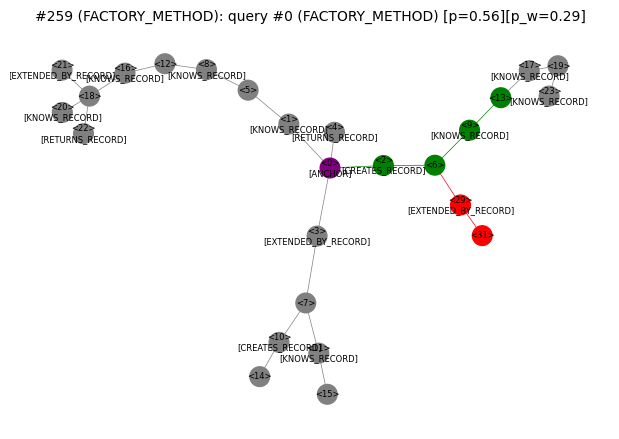

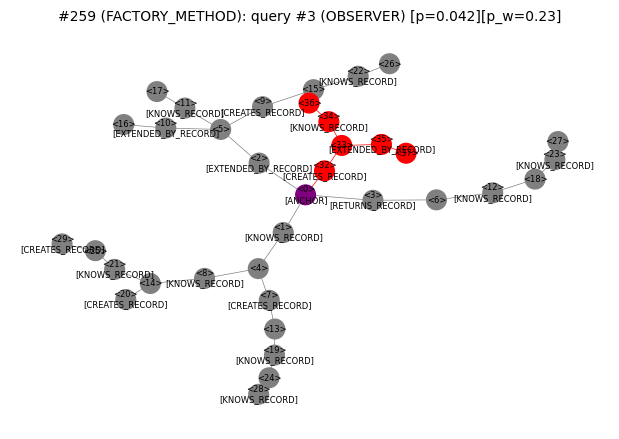

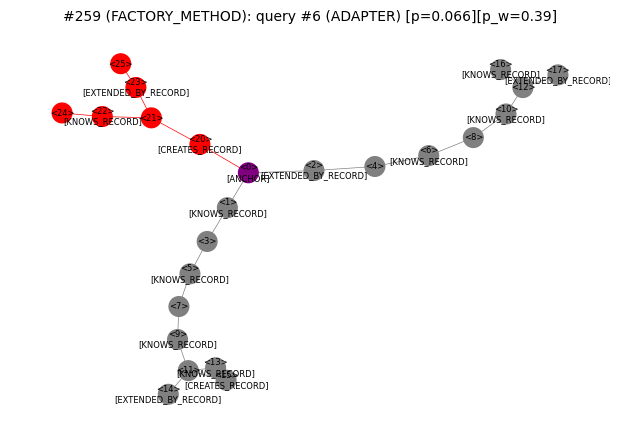

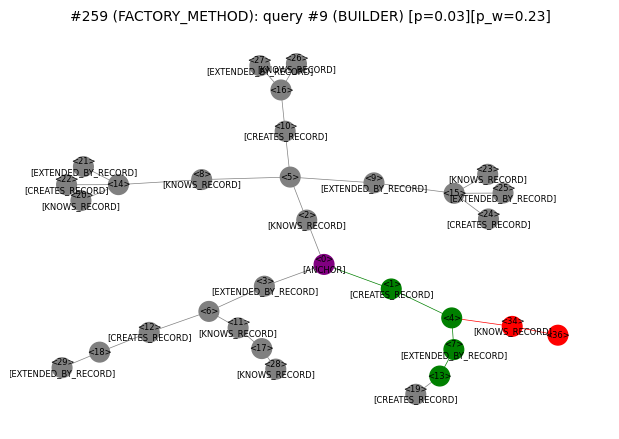

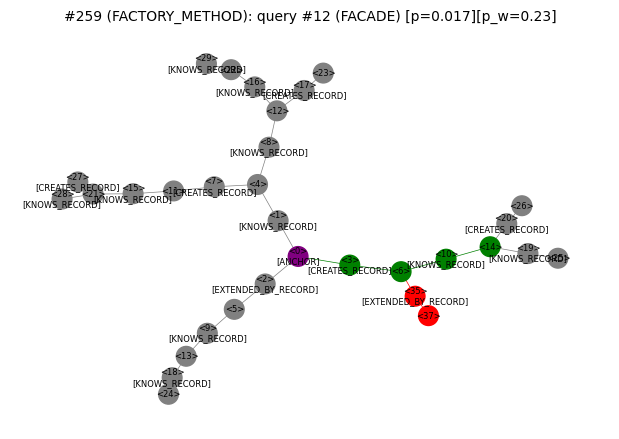

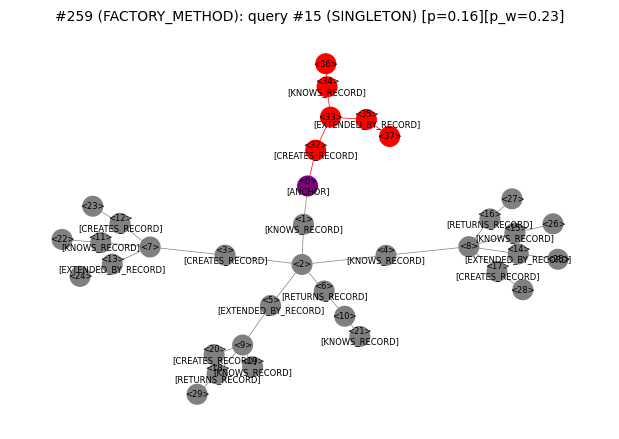

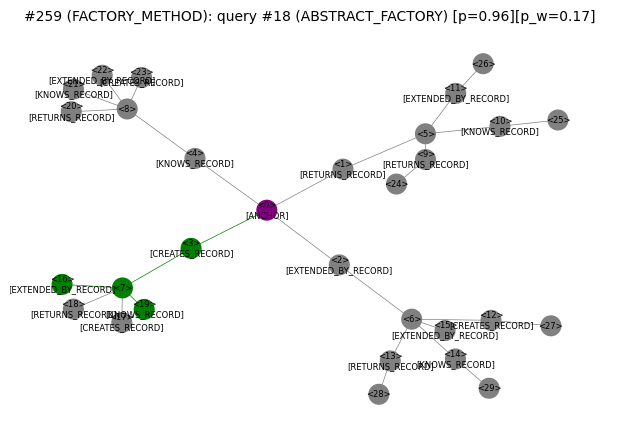

In [9]:
matching_colors = { 2: "purple", 1: "green", 0: "grey", -1: "red" }
example_gidx = next( iter( groups_by_source ) )
for pattern_type, idxs in groups_by_source[ example_gidx ].items():
    for idx in idxs[ :1 ]:
        source = sources[ idx ]
        query = queries[ idx ]
        pred = preds[ idx ]
        meta = metas[ idx ]
        source_type = meta.get( "source_type" )
        gidx = meta.get( "gidx" )
        p_w = meta.get( "pred_w", 1.0 )
        combined, node_colors, edge_colors = graph_utils.combine_normalized(
            source, query, matching_colors=matching_colors )
        plot_utils.plot_graph( combined,
                               title=f"#{gidx} ({source_type}): query #{idx} ({pattern_type}) [p={pred:.2}][p_w={p_w:.2}]",
                               nodeLabels=graph_utils.get_node_labels( combined ),
                               nodeColors=node_colors, edgeColors=edge_colors )

In [10]:
x_labels, y_labels = epm.to_numeric_labels( true_labels, pred_labels )
metrics = epm.compute_metrics( x_labels, y_labels )
print( f"Roc=[{metrics[ 'roc' ]:.3}] Acc=[{metrics[ 'acc' ]:.3}] "
       f"Prec=[{metrics[ 'pre' ]:.3}] Rec=[{metrics[ 'rec' ]:.3}] F1=[{metrics[ 'f1s' ]:.3}] "
       f"AvgPrec=[{metrics[ 'avp' ]:.3}]" )

Roc=[0.518] Acc=[0.167] Prec=[0.251] Rec=[0.167] F1=[0.156] AvgPrec=[0.169]


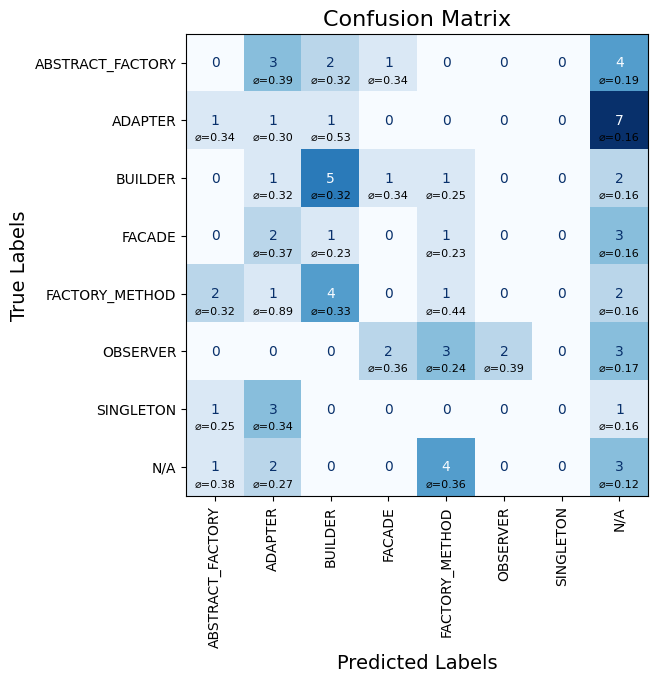

In [11]:
epm.compute_cm( true_labels, pred_labels, pred_scores )